# Exploratory Data Analysis
This notebook will focus on exploring data distributions and interesting findings relating to the features including generating relevant plots.

In [2]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("EDA")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g")  # Increase driver memory
    .config("spark.executor.memory", "16g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

24/10/14 13:22:42 WARN Utils: Your hostname, Melissas-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.13.89.149 instead (on interface en0)
24/10/14 13:22:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/14 13:22:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read Files
transactions = spark.read.parquet('../data/curated/flagged_fraud')
sa4_shapefile_path = '../data/external/SA4_2021_AUST_GDA2020.shp'
sa4_shapefile = gpd.read_file(sa4_shapefile_path)

24/10/14 13:22:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
transactions.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- consumer_weekly_transaction: long (nullable = true)
 |-- merchant_weekly_transaction: long (nullable = true)
 |-- is_

## Aggregating Dataset by SA4 Code

In [9]:
# Filter out rows where SA4 code is 'Unregistered'
filtered_transactions = transactions.filter(transactions['SA4_CODE_2011'] != 'Unregistered')

# Group by 'SA4_CODE_2011' and aggregate data
sa4_grouped_df = filtered_transactions.groupBy('SA4_CODE_2011').agg(
    F.count('order_id').alias('total_transactions'),
    F.countDistinct('user_id').alias('total_customers'),
    F.sum(F.when(F.col('is_fraud') == True, 1).otherwise(0)).alias('fraudulent_transactions'),
    F.avg('dollar_value').alias('avg_order_value'),
    F.mode('merchant_category').alias('popular_merchant_category')
)

sa4_grouped_df = sa4_grouped_df.toPandas()

## Generate Maps

In [10]:
# Merge shapefile with transactions data on SA4 code
merged_sa4 = sa4_shapefile.merge(sa4_grouped_df, left_on='SA4_CODE21', right_on='SA4_CODE_2011', how='left')

# Fill NA values with 0 for transaction columns
merged_sa4['total_transactions'].fillna(0, inplace=True)
merged_sa4['total_customers'].fillna(0, inplace=True)
merged_sa4['fraudulent_transactions'].fillna(0, inplace=True)

# Get the centroid of the SA4 map to initialize the folium map
center = merged_sa4.geometry.centroid.unary_union.centroid

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_8551/2719006247.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = merged_sa4.geometry.centroid.unary_union.centroid


### Plotting Areas with Most Transactions

In [19]:
m = folium.Map(location=[center.y, center.x], zoom_start=5)

folium.Choropleth(
    geo_data=merged_sa4.to_json(),
    name='choropleth',
    data=merged_sa4,
    columns=['SA4_CODE21', 'total_transactions'],
    key_on='feature.properties.SA4_CODE21',
    fill_color='YlGnBu', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Transactions',
).add_to(m)

# Add drop pins for top 3 areas with the most transactions
top_areas = merged_sa4.nlargest(3, 'total_transactions')
for idx, row in top_areas.iterrows():
    folium.Marker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        popup=f"Area: {row['SA4_NAME21']}\nTotal Transactions: {row['total_transactions']}",
    ).add_to(m)

folium.LayerControl().add_to(m)

# Comment out to show map
#m

### Plotting Areas with Most Customers

In [18]:
m2 = folium.Map(location=[center.y, center.x], zoom_start=5)

folium.Choropleth(
    geo_data=merged_sa4.to_json(),
    name='choropleth',
    data=merged_sa4,
    columns=['SA4_CODE21', 'total_customers'],
    key_on='feature.properties.SA4_CODE21',
    fill_color='YlGnBu', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Customers',
).add_to(m2)

# Add drop pins for top 3 areas with the most customers
top_areas = merged_sa4.nlargest(3, 'total_customers')
for idx, row in top_areas.iterrows():
    folium.Marker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        popup=f"Area: {row['SA4_NAME21']}\nTotal Customers: {row['total_customers']}",
    ).add_to(m2)

folium.LayerControl().add_to(m2)

# Comment out to show map
#m2

### Areas with Most Fraudulent Transactions

In [17]:
m3 = folium.Map(location=[center.y, center.x], zoom_start=5)

folium.Choropleth(
    geo_data=merged_sa4.to_json(),
    name='choropleth',
    data=merged_sa4,
    columns=['SA4_CODE21', 'fraudulent_transactions'],
    key_on='feature.properties.SA4_CODE21',
    fill_color='YlGnBu', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Fraudulent Transactions',
).add_to(m3)

# Add drop pins for top 3 areas with the most transactions
top_areas = merged_sa4.nlargest(3, 'fraudulent_transactions')
for idx, row in top_areas.iterrows():
    folium.Marker(
        location=[row['geometry'].centroid.y, row['geometry'].centroid.x],
        popup=f"Area: {row['SA4_NAME21']}\nFraudulent Transactions: {row['fraudulent_transactions']}",
    ).add_to(m3)

folium.LayerControl().add_to(m3)

# Comment out to show map
#m3

## Group Transactions by Merchant Category

In [21]:
# Total Transaction Count per Merchant
merchant_category_transactions = transactions.groupBy("merchant_category").agg(
    F.count("order_id").alias("transaction_count")
)

merchant_category_transactions.orderBy(F.desc("transaction_count")).show(truncate=False, n=25)


+-------------------------------------------------------------------------------------+-----------------+
|merchant_category                                                                    |transaction_count|
+-------------------------------------------------------------------------------------+-----------------+
|tent and awning shops                                                                |2704641          |
|gift, card, novelty, and souvenir shops                                              |1878334          |
|digital goods: books, movies, music                                                  |1470374          |
|watch, clock, and jewelry repair shops                                               |1181872          |
|cable, satellite, and other pay television and radio services                        |1095775          |
|florists supplies, nursery stock, and flowers                                        |1010012          |
|opticians, optical goods, and eyeglasses     

In [22]:
# Number of Merchants in each Category
merchant_category_merchant_count = transactions.groupBy("merchant_category").agg(
    F.countDistinct("merchant_abn").alias("merchant_count")
)

merchant_category_merchant_count.orderBy(F.desc("merchant_count")).show(truncate=False, n=25)

+-------------------------------------------------------------------------------------+--------------+
|merchant_category                                                                    |merchant_count|
+-------------------------------------------------------------------------------------+--------------+
|tent and awning shops                                                                |521           |
|digital goods: books, movies, music                                                  |195           |
|artist supply and craft shops                                                        |193           |
|computer programming , data processing, and integrated systems design services       |190           |
|shoe shops                                                                           |185           |
|gift, card, novelty, and souvenir shops                                              |182           |
|furniture, home furnishings and equipment shops, and manufacturers, exce

In [5]:
# Average Order Value of Merchant Categories
merchant_aov = transactions.groupBy("merchant_category").agg(
    F.avg("dollar_value").alias("aov")
)

merchant_aov.orderBy(F.desc("aov")).show(truncate=False, n=25)

+-------------------------------------------------------------------------------------+------------------+
|merchant_category                                                                    |aov               |
+-------------------------------------------------------------------------------------+------------------+
|art dealers and galleries                                                            |796.7014125814322 |
|jewelry, watch, clock, and silverware shops                                          |695.7849625760413 |
|telecom                                                                              |551.8631465797193 |
|stationery, office supplies and printing and writing paper                           |445.0290448163807 |
|equipment, tool, furniture, and appliance rent al and leasing                        |418.825210590407  |
|health and beauty spas                                                               |295.4037188040752 |
|motor vehicle supplies and new parts

In [6]:
# Total Transaction Count per Merchant
merchant_customers = transactions.groupBy("merchant_category").agg(
    F.count("user_id").alias("customer_count")
)

merchant_customers.orderBy(F.desc("customer_count")).show(truncate=False, n=25)

+-------------------------------------------------------------------------------------+--------------+
|merchant_category                                                                    |customer_count|
+-------------------------------------------------------------------------------------+--------------+
|tent and awning shops                                                                |2704641       |
|gift, card, novelty, and souvenir shops                                              |1878334       |
|digital goods: books, movies, music                                                  |1470374       |
|watch, clock, and jewelry repair shops                                               |1181872       |
|cable, satellite, and other pay television and radio services                        |1095775       |
|florists supplies, nursery stock, and flowers                                        |1010012       |
|opticians, optical goods, and eyeglasses                                

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_8551/2777900153.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


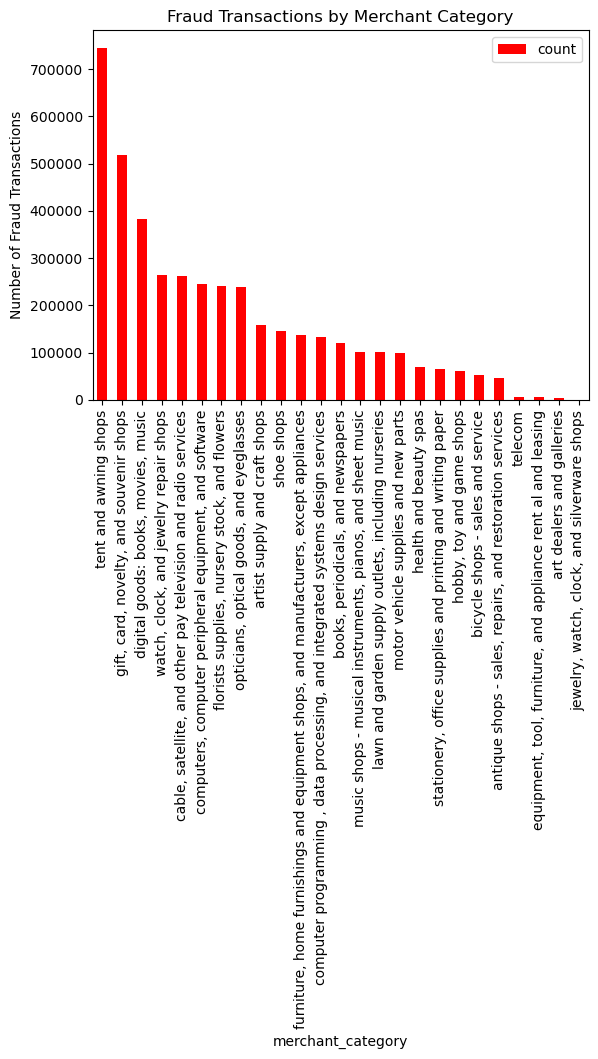

In [35]:
# Fraud transactions by merchant category
fraud_category = transactions.filter("is_fraud == true").groupBy("merchant_category").count()
fraud_category_df = fraud_category.orderBy(F.desc("count")).toPandas()

fraud_category_df.plot(kind='bar', x='merchant_category', y='count', color='red')
plt.title("Fraud Transactions by Merchant Category")
plt.ylabel("Number of Fraud Transactions")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Close the previous plot to avoid any overlap
plt.close()

/var/folders/nb/ptvngvk147s5wfkvdykjdlvm0000gn/T/ipykernel_8551/3468446388.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


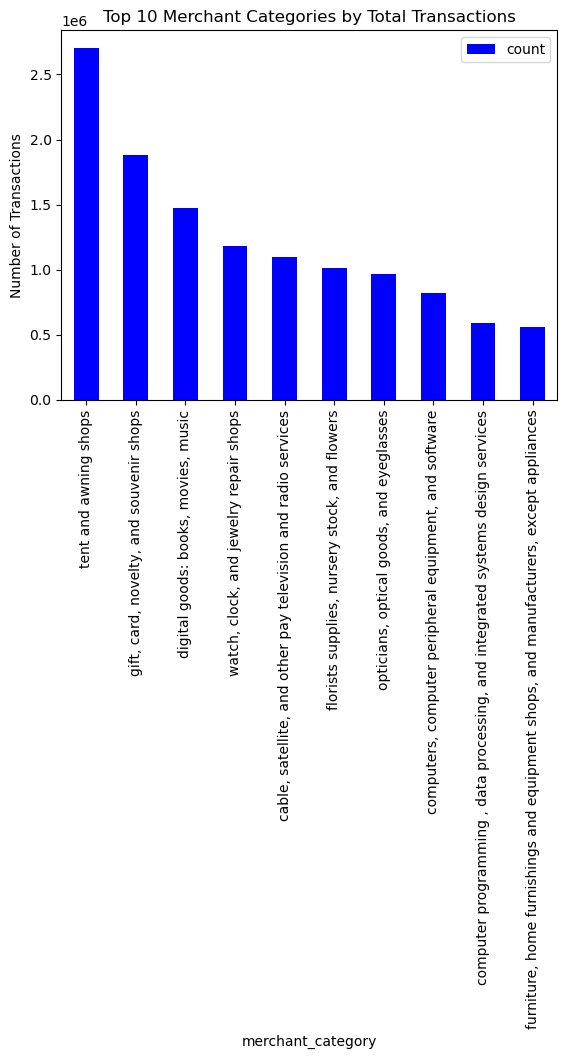

In [36]:
top_categories = transactions.groupBy("merchant_category").count().orderBy(F.desc("count"))
top_categories_df = top_categories.limit(10).toPandas()

top_categories_df.plot(kind='bar', x='merchant_category', y='count', color='blue')
plt.title("Top 10 Merchant Categories by Total Transactions")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

<Axes: >

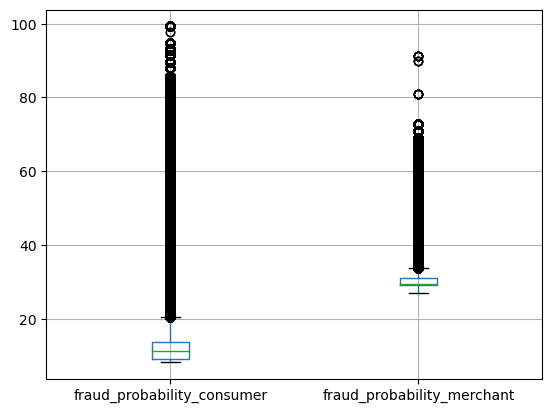

In [24]:
transactions.select("fraud_probability_consumer", "fraud_probability_merchant").toPandas().boxplot()

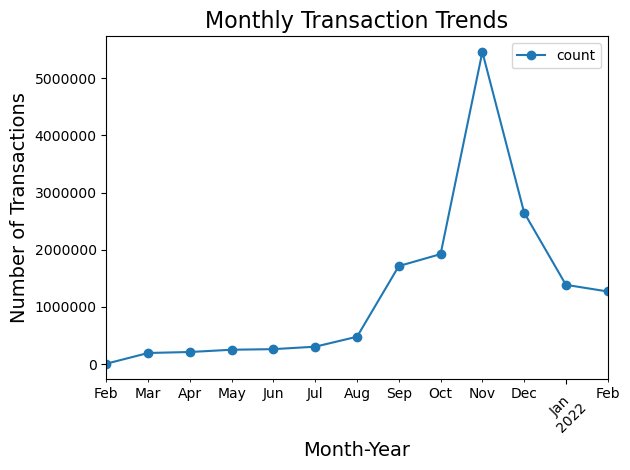

24/10/02 14:16:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 152835 ms exceeds timeout 120000 ms
24/10/02 14:16:19 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/02 14:16:19 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [4]:
# Transactions over time
monthly_transactions = transactions.groupBy("order_month_year").count().orderBy("order_month_year")
monthly_transactions_df = monthly_transactions.toPandas()

# Convert 'order_month_year' to datetime format for proper sorting
monthly_transactions_df['order_month_year'] = pd.to_datetime(monthly_transactions_df['order_month_year'], format='%b-%y')

# Sort by the datetime column
monthly_transactions_df = monthly_transactions_df.sort_values('order_month_year')

monthly_transactions_df.plot(kind='line', x='order_month_year', y='count', marker='o')

# Set the title and labels
plt.title('Monthly Transaction Trends', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)

plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()